# Building Diffuser Pipeline

> Learn how to build a diffuser pipeline

based on https://huggingface.co/docs/diffusers/using-diffusers/write_own_pipeline

In [ ]:
#| default_exp DiffusersPipeline

In [ ]:
#| hide
from nbdev.showdoc import *
from reinautils import *

In [ ]:
#| hide
import warnings
warnings.filterwarnings(action='ignore')
import numpy as np
import matplotlib.pylab as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pickle
%load_ext autoreload
%autoreload 2
%matplotlib inline

Load necessary modules

In [ ]:
#| export
from PIL import Image
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler
from diffusers import UniPCMultistepScheduler
from tqdm.auto import tqdm

2023-04-15 13:18:45.890937: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/opt/conda/lib
2023-04-15 13:18:45.891040: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/opt/conda/lib
2023-04-15 13:18:45.891049: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlo

Setup the notebook's configuration parameters

In [ ]:
params=Parameters().from_json('../config.json')

In [ ]:
params.gpu = device_by_name("Tesla")
params.height = 512  # default height of Stable Diffusion
params.width = 512  # default width of Stable Diffusion
params.num_inference_steps = 25  # Number of denoising steps
params.guidance_scale = 7.5  # Scale for classifier-free guidance
params.seed = 4356

In [ ]:
device=params.gpu

load and define the diffusers's building blocks

In [ ]:
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder = "vae").to(device)
tokenizer = CLIPTokenizer.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder = "tokenizer")
text_encoder = CLIPTextModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder = "text_encoder").to(device)
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder = "unet").to(device)

Define the scheduler

In [ ]:
scheduler = UniPCMultistepScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

Setup prompt

In [ ]:
prompt = ["a photograph of a cute puppy"]
generator = torch.manual_seed(params.seed)  # Seed generator to create the inital latent noise
batch_size = len(prompt)

calculate the embeddings from the prompt

In [ ]:
text_input = tokenizer(
    prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt"
)

with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

calculate the embeddings for an empty prompt

In [ ]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]

The model's input is a concatenation of the prompt's and the null prompt's embeddings

In [ ]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

Generate some initial random noise as a starting point for the diffusion process in the latent space

In [ ]:
latents = torch.randn(
    (batch_size, unet.in_channels, params.height // 8, params.width // 8),
    generator=generator,
)
latents = latents.to(device)

Start by scaling the input with the initial noise distribution, sigma, the noise scale value

In [ ]:
latents = latents * scheduler.init_noise_sigma

Here is the denoising loop where the magic is done

In [ ]:
scheduler.set_timesteps(params.num_inference_steps)

for t in tqdm(scheduler.timesteps):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + params.guidance_scale * (noise_pred_text - noise_pred_uncond)
    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample


  0%|          | 0/25 [00:00<?, ?it/s]

The final step is to use the vae to decode the latent representation into an image

In [ ]:
# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

Lastly, convert the image to a PIL

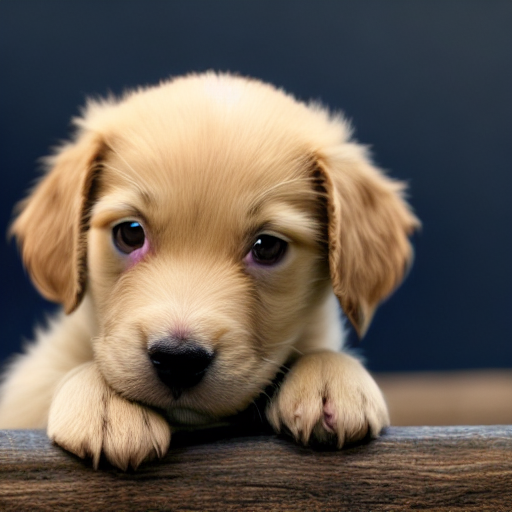

In [ ]:
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()